# Overview

What separates Hall of Fame baseball players from the rest? In particular, I was curious about what features separate Hall of Fame players versus the ones who were nominated but inducted. 

In other words, what separates the Hall of Fame from the Hall of Very Good?

In [262]:
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.display import display

%matplotlib inline
pd.set_option('display.max_columns', None)

We use the Hall of Fame dataset to see who was inducted or not and merge with the Master set so we can see the players names.

In [263]:
hof_df = pd.read_csv('baseballdatabank-master/core/HallOfFame.csv')
master_df = pd.read_csv('baseballdatabank-master/core/Master.csv')

hof_cols = ['playerID', 'nameFirst', 'nameLast'] + list(hof_df.columns[1:]) 

hof_df = hof_df.merge(master_df, on='playerID')
hof_df = hof_df[hof_cols]

hof_df.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,NaN
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,NaN
3,wagneho01,Honus,Wagner,1936,Veterans,78.0,59.0,5.0,N,Player,NaN
4,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,NaN


Since each row in the Hall of Fame set reflects a voting record, we group by playerID to remove duplicate rows. We end up with a single data frame of players, where the `inducted` field marks whether or not they are in the Hall of Fame.

There are 247 inducted players and 941 non-inducted players in this dataset.

In [264]:
# Just want PlayerID and Inducted, remove duplicate No vote records

player_votes = hof_df.loc[(hof_df.category == 'Player')]
inducted_players = hof_df.loc[(hof_df.inducted == 'Y') & (hof_df.category == 'Player')]

non_inducted_ids = set(player_votes.playerID).difference(inducted_players.playerID)

non_inducted_players = player_votes.loc[hof_df.playerID.isin(non_inducted_ids)]
non_inducted_players = non_inducted_players.groupby('playerID', as_index=False).last()

print("# of Inducted Players: %d" % inducted_players.shape[0])
print("# of Non-Inducted Players: %d" % non_inducted_players.shape[0])

nominated_players = inducted_players.append(non_inducted_players, ignore_index=True)
display(nominated_players.shape)

# of Inducted Players: 247
# of Non-Inducted Players: 941


(1188, 11)

## Awards
We add in Awards players won over the course of their career. It seems plausible that awards would be correlated with entrance into the Hall.

In [265]:
awards = pd.read_csv("baseballdatabank-master/core/AwardsPlayers.csv")

award_count = awards.groupby('playerID').size().reset_index()
award_count.columns = ['playerID', 'Awards']

# Convert each award into a column
award_columns = awards[['playerID', 'awardID']].pivot_table(index='playerID', columns='awardID', 
                                                            aggfunc=np.count_nonzero, fill_value=0)

nominated_players = pd.merge(nominated_players, award_columns.reset_index(), on='playerID', how='left')
nominated_players = pd.merge(nominated_players, award_count, on='playerID', how='left')

nominated_players.fillna(0, inplace=True)

nominated_players.head()

,playerID,nameFirst,nameLast,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards
0,cobbty01,Ty,Cobb,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0
1,ruthba01,Babe,Ruth,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
2,wagneho01,Honus,Wagner,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
3,mathech01,Christy,Mathewson,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,johnswa01,Walter,Johnson,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0


By looking at summary statistics and histograms, it seems like the 

In [266]:
display(nominated_players[nominated_players.inducted == 'Y'].Awards.describe())
display(nominated_players[nominated_players.inducted == 'N'].Awards.describe())

count    247.000000
mean       9.210526
std        9.297489
min        0.000000
25%        1.000000
50%        7.000000
75%       14.000000
max       39.000000
Name: Awards, dtype: float64

count    941.000000
mean       2.380446
std        3.611713
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       47.000000
Name: Awards, dtype: float64

In [267]:
def plot_awards(df, title, bins=10):
    ax = df['Awards'].hist(bins=bins)
    ax.set_xlabel("Number of Awards")
    ax.set_ylabel("Count")
    ax.set_title(title)

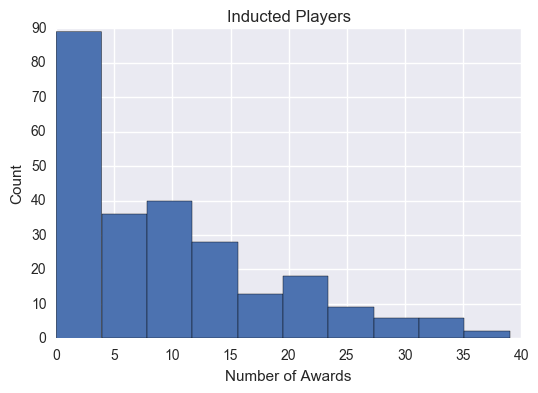

In [269]:
plot_awards(nominated_players[nominated_players.inducted == 'Y'], 'Inducted Players')

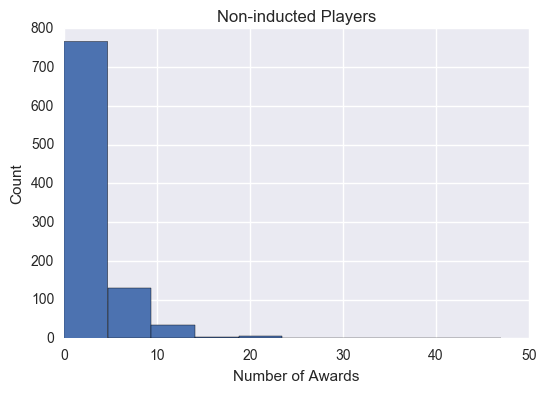

In [270]:
plot_awards(nominated_players[nominated_players.inducted == 'N'], 'Non-inducted Players')

# Games
Number of games played could approximate longevity.

In [253]:
def cumulative_stats(csv_path, display_head=True, agg_dict=None):
    df = pd.read_csv(csv_path)
    
    if display_head == True:
        display(df.head())
    
    df_total = None
    
    if agg_dict is None:
        df_total = df.groupby('playerID', as_index=False).sum()
        del df_total['yearID']
    else:
        df_total = df.groupby('playerID', as_index=False).agg(agg_dict)
    
    return df_total

# Merge with Appearances
appearances_total = cumulative_stats("baseballdatabank-master/core/Appearances.csv")

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,BS1,NaN,barnero01,31.0,NaN,31,31.0,0,0,0,16,0,15,0,0,0,0,NaN,NaN,NaN
1,1871,BS1,NaN,barrofr01,18.0,NaN,18,18.0,0,0,0,1,0,0,13,0,4,17,NaN,NaN,NaN
2,1871,BS1,NaN,birdsda01,29.0,NaN,29,29.0,0,7,0,0,0,0,0,0,27,27,NaN,NaN,NaN
3,1871,BS1,NaN,conefr01,19.0,NaN,19,19.0,0,0,0,0,0,0,18,0,1,18,NaN,NaN,NaN
4,1871,BS1,NaN,gouldch01,31.0,NaN,31,31.0,0,0,30,0,0,0,0,0,1,1,NaN,NaN,NaN


We also use the appearances data to determine the player's most played position.

In [254]:
nominated_players = pd.merge(nominated_players, appearances_total, on='playerID')

position_cols = ['G_p','G_c','G_1b','G_2b',
                 'G_3b','G_ss','G_lf','G_cf',
                 'G_rf','G_of','G_dh','G_ph','G_pr']

def most_played_position(df):
    return df[position_cols].idxmax(axis=1).str.split('_').str[1].str.upper()

nominated_players.insert(3, 'Position', most_played_position(nominated_players))
display(nominated_players.head())

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,Y,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0,3034.0,NaN,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,NaN,NaN,NaN
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,2503.0,NaN,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,NaN,NaN,NaN
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,Y,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2794.0,NaN,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,NaN,NaN,NaN
3,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,Y,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,647.0,NaN,647,647.0,636,0,3,0,0,0,1,0,3,4,NaN,NaN,NaN
4,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,Y,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,934.0,NaN,934,934.0,802,0,0,0,0,0,2,7,4,13,NaN,NaN,NaN


In [255]:
# Convert inducted Y/N to numeric for corrplot later
def convert_inducted_to_numeric(s):
    if s == 'Y':
        return 1
    else:
        return 0

nominated_players['inducted'] = nominated_players['inducted'].apply(convert_inducted_to_numeric)

In [256]:
def plot_total_games(df, title, bins=50):
    ax = df['G_all'].hist(bins=bins)
    ax.set_xlabel("Total games played")
    ax.set_ylabel("Count")
    ax.set_title(title)

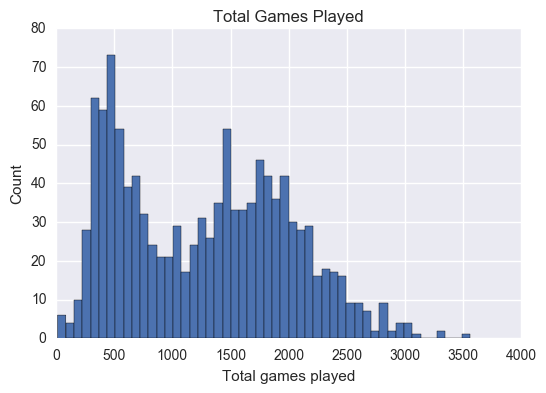

In [257]:
plot_total_games(nominated_players, 'Total Games Played')

# Pitching

In [212]:
# Merge with Pitching
agg_dict = {'ERA': np.mean, 'W': np.sum}
pitching_total = cumulative_stats("baseballdatabank-master/core/Pitching.csv", 
                                  display_head=False,
                                  agg_dict=agg_dict)

pitchers = nominated_players.loc[nominated_players.Position == 'P']
pitchers = pd.merge(pitchers, pitching_total, on='playerID')

pitchers.head()

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,ERA,W
0,mathech01,Christy,Mathewson,P,1936,BBWAA,226.0,170.0,205.0,1,Player,0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,647.0,NaN,647,647.0,636,0,3,0,0,0,1,0,3,4,NaN,NaN,NaN,2.648889,373
1,johnswa01,Walter,Johnson,P,1936,BBWAA,226.0,170.0,189.0,1,Player,0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,934.0,NaN,934,934.0,802,0,0,0,0,0,2,7,4,13,NaN,NaN,NaN,2.348095,417
2,youngcy01,Cy,Young,P,1937,BBWAA,201.0,151.0,153.0,1,Player,0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,918.0,NaN,918,918.0,906,0,5,0,0,0,0,0,0,0,NaN,NaN,NaN,2.713913,511
3,alexape01,Pete,Alexander,P,1938,BBWAA,262.0,197.0,212.0,1,Player,0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,703.0,NaN,703,703.0,696,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,2.972381,373
4,wadderu01,Rube,Waddell,P,1946,Old Timers,0.0,0.0,0.0,1,Player,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,410.0,NaN,410,410.0,407,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,2.901429,193


In [213]:
def corr_plot(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 7))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, xticklabels=corr.columns.values, 
                yticklabels=corr.columns.values,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

    ax.set_title("Correlation plot");

,G_all,ERA,W,Cy Young Award,Awards,inducted
G_all,1.000000,-0.255805,0.297535,0.100397,0.241040,0.261107
ERA,-0.255805,1.000000,-0.295432,-0.097057,-0.184626,-0.316926
W,0.297535,-0.295432,1.000000,0.279575,0.467042,0.611305
Cy Young Award,0.100397,-0.097057,0.279575,1.000000,0.521430,0.261780
Awards,0.241040,-0.184626,0.467042,0.521430,1.000000,0.472801
inducted,0.261107,-0.316926,0.611305,0.261780,0.472801,1.000000


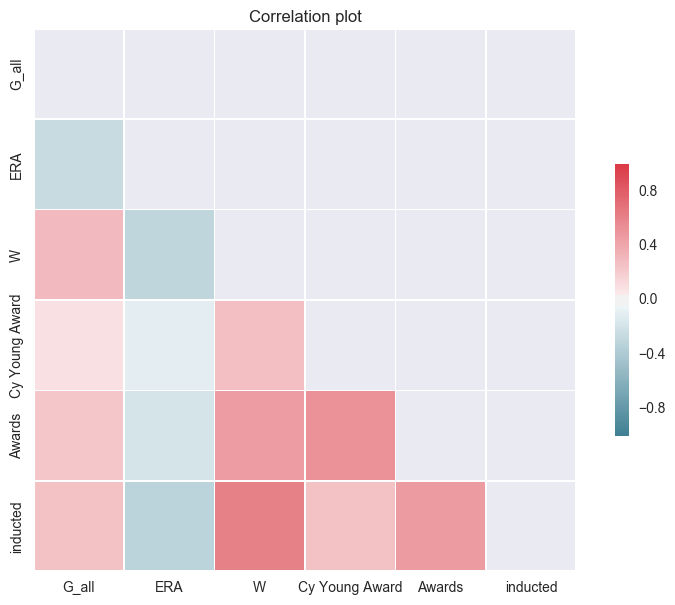

In [231]:
display(pitchers[['G_all', 'ERA', 'W', 'Cy Young Award', 'Awards', 'inducted']].corr())
corr_plot(pitchers[['G_all', 'ERA', 'W', 'Cy Young Award', 'Awards', 'inducted']].corr())

# Non-Pitchers

In [215]:
def slugging_pct(df):
    return ((df['H'] - df['2B'] - df['3B'] - df['HR']) + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']

def on_base_pct(df):
    return (df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['SF'] + df['HBP'])

def on_base_plus_slugging(df):
    return on_base_pct(df) + slugging_pct(df)

In [216]:
# Merge with Batting
batting_total = cumulative_stats("baseballdatabank-master/core/Batting.csv", 
                                  display_head=False)
non_pitchers = nominated_players.loc[nominated_players.Position != 'P']
non_pitchers = pd.merge(non_pitchers, batting_total, on='playerID')

non_pitchers.fillna(0, inplace=True)

non_pitchers['BA'] = non_pitchers.H / non_pitchers.AB
non_pitchers['SLG'] = slugging_pct(non_pitchers)
non_pitchers['OBP'] = on_base_pct(non_pitchers)
non_pitchers['OPS'] = on_base_plus_slugging(non_pitchers)

non_pitchers.head()

,playerID,nameFirst,nameLast,Position,yearid,votedBy,ballots,needed,votes,inducted,category,needed_note,ALCS MVP,All-Star Game MVP,Babe Ruth Award,Baseball Magazine All-Star,Branch Rickey Award,Comeback Player of the Year,Cy Young Award,Gold Glove,Hank Aaron Award,Hutch Award,Lou Gehrig Memorial Award,Most Valuable Player,NLCS MVP,Pitching Triple Crown,Roberto Clemente Award,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,TSN All-Star,TSN Fireman of the Year,TSN Guide MVP,TSN Major League Player of the Year,TSN Pitcher of the Year,TSN Player of the Year,TSN Reliever of the Year,Triple Crown,World Series MVP,Awards,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,BA,SLG,OBP,OPS
0,cobbty01,Ty,Cobb,OF,1936,BBWAA,226.0,170.0,222.0,1,Player,0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,31.0,3034.0,0.0,3034,3034.0,3,0,14,2,1,0,35,2194,706,2934,0.0,0.0,0.0,24,3035,11434.0,2246.0,4189.0,724.0,295.0,117.0,1937.0,892.0,178.0,1249.0,357.0,0.0,94.0,295.0,0.0,0.0,0.366363,0.511982,0.432965,0.944947
1,ruthba01,Babe,Ruth,OF,1936,BBWAA,226.0,170.0,215.0,1,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,2503.0,0.0,2503,2503.0,163,0,32,0,0,0,1057,64,1131,2241,0.0,0.0,0.0,22,2503,8398.0,2174.0,2873.0,506.0,136.0,714.0,2217.0,123.0,117.0,2062.0,1330.0,0.0,43.0,113.0,0.0,2.0,0.342105,0.689807,0.473960,1.163767
2,wagneho01,Honus,Wagner,SS,1936,BBWAA,226.0,170.0,215.0,1,Player,0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2794.0,0.0,2794,2794.0,2,0,248,57,210,1887,35,67,272,373,0.0,0.0,0.0,21,2792,10430.0,1736.0,3415.0,640.0,252.0,101.0,1732.0,722.0,15.0,963.0,327.0,0.0,125.0,221.0,0.0,0.0,0.327421,0.466155,0.390953,0.857109
3,lajoina01,Nap,Lajoie,2B,1937,BBWAA,201.0,151.0,168.0,1,Player,0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,2480.0,0.0,2480,2480.0,0,0,286,2035,21,73,4,5,18,26,0.0,0.0,0.0,23,2480,9589.0,1504.0,3242.0,657.0,163.0,83.0,1599.0,380.0,21.0,516.0,85.0,0.0,134.0,221.0,0.0,0.0,0.338096,0.466576,0.380115,0.846692
4,speaktr01,Tris,Speaker,OF,1937,BBWAA,201.0,151.0,165.0,1,Player,0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,2789.0,0.0,2789,2789.0,1,0,18,0,0,0,2,2690,6,2698,0.0,0.0,0.0,22,2789,10195.0,1882.0,3514.0,792.0,222.0,117.0,1529.0,432.0,129.0,1381.0,220.0,0.0,103.0,309.0,0.0,0.0,0.344679,0.500343,0.427948,0.928291


In [217]:
list(batting_total.columns)

['playerID',
 'stint',
 'G',
 'AB',
 'R',
 'H',
 '2B',
 '3B',
 'HR',
 'RBI',
 'SB',
 'CS',
 'BB',
 'SO',
 'IBB',
 'HBP',
 'SH',
 'SF',
 'GIDP']

,Games Played,Runs,Runs Batted In,Home Runs,Hits,Stolen Bases,Strike Outs,Batting Average,On-base Percentage,Slugging Average,On-base Plus Slugging,Awards,Inducted
G_all,1.000000,0.861047,0.820544,0.575577,0.934841,0.375147,0.578649,0.336887,0.407334,0.399877,0.438649,0.522459,0.406961
R,0.861047,1.000000,0.841348,0.559531,0.938992,0.546403,0.453176,0.567232,0.559293,0.617900,0.627987,0.557044,0.545905
RBI,0.820544,0.841348,1.000000,0.801517,0.850516,0.186643,0.589837,0.490910,0.757632,0.534739,0.737863,0.598187,0.492232
HR,0.575577,0.559531,0.801517,1.000000,0.506334,-0.078652,0.808906,0.151659,0.790185,0.358837,0.695339,0.528992,0.238761
H,0.934841,0.938992,0.850516,0.506334,1.000000,0.451524,0.435373,0.578296,0.490877,0.510746,0.539385,0.563018,0.523258
SB,0.375147,0.546403,0.186643,-0.078652,0.451524,1.000000,0.028610,0.267576,-0.029816,0.234519,0.066347,0.129495,0.263113
SO,0.578649,0.453176,0.589837,0.808906,0.435373,0.028610,1.000000,-0.078079,0.517390,0.152390,0.424471,0.343688,0.036438
BA,0.336887,0.567232,0.490910,0.151659,0.578296,0.267576,-0.078079,1.000000,0.597648,0.745959,0.703033,0.354034,0.448893
SLG,0.407334,0.559293,0.757632,0.790185,0.490877,-0.029816,0.517390,0.597648,1.000000,0.671101,0.960955,0.478233,0.338724
OBP,0.399877,0.617900,0.534739,0.358837,0.510746,0.234519,0.152390,0.745959,0.671101,1.000000,0.850037,0.373771,0.400916


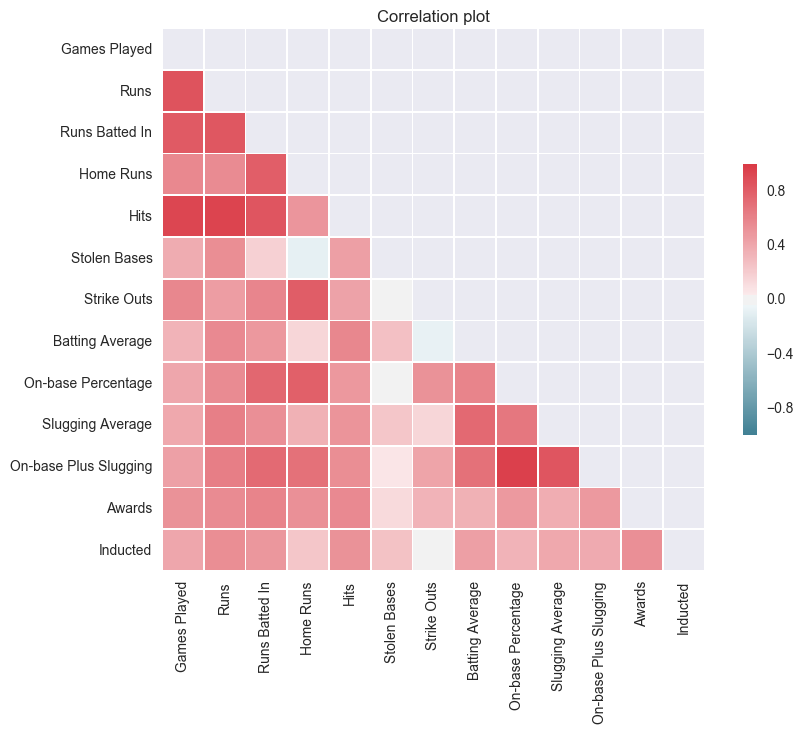

In [232]:
batting_corr = non_pitchers[['G_all', 'R', 'RBI', 'HR', 'H', 'SB', 'SO', 'BA', 'SLG', 'OBP', 'OPS', 'Awards','inducted']].corr()
batting_corr.columns = ['Games Played', 'Runs', 'Runs Batted In', 'Home Runs', 
                        'Hits', 'Stolen Bases', 'Strike Outs', 'Batting Average', 
                        'On-base Percentage', 'Slugging Average', 'On-base Plus Slugging', 'Awards',
                        'Inducted']
display(batting_corr)
corr_plot(batting_corr)

In [219]:
# Merge with Awards
awards = pd.read_csv("baseballdatabank-master/core/AwardsPlayers.csv")

display(awards.awardID.value_counts())

award_count = awards.groupby('playerID').size().reset_index()
award_count.columns = ['playerID', 'Awards']

#pd.merge(nominated_players, awards)

Baseball Magazine All-Star             1520
TSN All-Star                           1350
Gold Glove                             1055
Silver Slugger                          649
Most Valuable Player                    192
Rookie of the Year                      138
TSN Pitcher of the Year                 135
Cy Young Award                          110
TSN Player of the Year                   92
TSN Fireman of the Year                  88
TSN Major League Player of the Year      81
Rolaids Relief Man Award                 74
Babe Ruth Award                          64
World Series MVP                         63
Lou Gehrig Memorial Award                57
All-Star Game MVP                        55
Hutch Award                              48
Roberto Clemente Award                   46
NLCS MVP                                 39
Pitching Triple Crown                    38
ALCS MVP                                 35
Hank Aaron Award                         34
TSN Guide MVP                   

In [220]:
inducted_awards = pd.merge(inducted_players, awards, how='left', on='playerID')

In [221]:
non_inducted_awards = pd.merge(non_inducted_players, awards, how='left', on='playerID')

In [222]:
inducted_awards.awardID.value_counts()

Baseball Magazine All-Star             861
TSN All-Star                           547
Gold Glove                             239
Silver Slugger                         126
Most Valuable Player                    96
TSN Player of the Year                  48
TSN Pitcher of the Year                 47
Cy Young Award                          41
TSN Major League Player of the Year     40
Pitching Triple Crown                   27
TSN Guide MVP                           25
Lou Gehrig Memorial Award               24
All-Star Game MVP                       19
Babe Ruth Award                         19
World Series MVP                        17
Roberto Clemente Award                  16
Rookie of the Year                      15
Triple Crown                            14
TSN Fireman of the Year                 13
Hutch Award                             12
Rolaids Relief Man Award                12
Branch Rickey Award                      7
ALCS MVP                                 5
NLCS MVP   

In [223]:
non_inducted_awards.awardID.value_counts()

TSN All-Star                           565
Gold Glove                             461
Baseball Magazine All-Star             434
Silver Slugger                         237
Most Valuable Player                    63
TSN Pitcher of the Year                 55
TSN Fireman of the Year                 48
Rookie of the Year                      48
Cy Young Award                          40
TSN Player of the Year                  37
Rolaids Relief Man Award                34
World Series MVP                        28
Babe Ruth Award                         27
TSN Major League Player of the Year     25
Lou Gehrig Memorial Award               24
Hutch Award                             20
All-Star Game MVP                       19
Roberto Clemente Award                  18
NLCS MVP                                16
ALCS MVP                                13
TSN Guide MVP                            7
Branch Rickey Award                      6
Pitching Triple Crown                    5
Hank Aaron 

In [224]:
display(inducted_awards.groupby('playerID').awardID.count().describe())
display(non_inducted_awards.groupby('playerID').awardID.count().describe())


count    247.000000
mean       9.210526
std        9.297489
min        0.000000
25%        1.000000
50%        7.000000
75%       14.000000
max       39.000000
Name: awardID, dtype: float64

count    941.000000
mean       2.380446
std        3.611713
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       47.000000
Name: awardID, dtype: float64

In [225]:
award_columns = awards[['playerID', 'awardID']].pivot_table(index='playerID', columns='awardID', aggfunc=np.count_nonzero, fill_value=0)

In [226]:
awards.pivot_table(index='playerID', columns='awardID', aggfunc=np.count_nonzero, fill_value=0)

yearID                                    \
awardID   ALCS MVP All-Star Game MVP Babe Ruth Award   
playerID                                               
aaronha01        0                 0               0   
abbotji01        0                 0               0   
abernte02        0                 0               0   
abreubo01        0                 0               0   
abreujo02        0                 0               0   
adamsba01        0                 0               0   
ageeto01         0                 0               0   
ainsmed01        0                 0               0   
akerja01         0                 0               0   
alexape01        0                 0               0   
alfonan01        0                 0               0   
alfoned01        0                 0               0   
allendi01        0                 0               0   
allenjo02        0                 0               0   
alleyge01        0                 0               0   
allisbo01        0                 0               0   
alomaro01        1                 1               0   
alomasa02        0                 1               0   
aloufe01         0                 0               0   
alouma01         0                 0               0   
aloumo01         0                 0               1   
altuvjo01        0                 0               0   
alvarpe01        0                 0               0   
amaroru01        0                 0               0   
anderga01        0                 1               0   
andujjo01        0                 0               0   
antonjo02        0                 0               0   
aparilu01        0                 0               0   
applilu01        0                 0               0   
archeji01        0                 0               0   
...            ...               ...             ...   
woodjo02         0                 0               0   
woodke02         0                 0               0   
woodwi01         0                 0               0   
worreto01        0                 0               0   
wrighda03        0                 0               0   
wrighgl01        0                 0               0   
wyattwh01        0                 0               0   
wynnea01         0                 0               0   
wynnji01         0                 0               0   
wyseha01         0                 0               0   
yastrca01        0                 1               0   
yeagest01        0                 0               0   
yelicch01        0                 0               0   
yorkru01         0                 0               0   
youklke01        0                 0               0   
youngch03        0                 0               0   
youngcy01        0                 0               0   
youngde03        1                 0               0   
youngdm01        0                 0               0   
younger01        0                 0               0   
youngmi02        0                 1               0   
youngro01        0                 0               0   
yountro01        0                 0               0   
zachrpa01        0                 0               0   
zahnge01         0                 0               0   
zambrca01        0                 0               0   
zimmehe01        0                 0               0   
zimmery01        0                 0               0   
ziskri01         0                 0               0   
zitoba01         0                 0               0   

                                                          \
awardID   Baseball Magazine All-Star Branch Rickey Award   
playerID                                                   
aaronha01                          0                   0   
abbotji01                          0                   0   
abernte02                          0                   0   
abreubo01                          0                   0   
abreujo

# Future Directions
Break down by era
Look for fielding statistics
Veterans vs BBWA